**Error]** **<span style="color:Orange">에러명</span>**: 사유

# 인공지능으로 세상에 없던 새로운 패션 만들기
-----
### 프로젝트 - CIFAR-10 이미지 생성하기

## 실습목표

>* 생성 모델링 개념을 이해하며 판별 모델링과의 차이 알기
>* Pix2Pix, CycleGAN 등의 이미지 관련 다양한 생성 모델링의 응용을 접하며 흥미 가지기
>* Fashion MNIST 데이터셋의 의미를 알기
>* 생성적 적대 신경망(GAN)의 구조와 원리를 이해하기
>* 텐서플로우로 짠 DCGAN 학습 코드를 익히며 응용하기

## 순서
> **Step1.** 작업환경 구성하기<br>
**Step2.** 데이터셋 구성하기<br>
**Step3.** 생성자 모델 구현하기<br>
**Step4.** 판별자 모델 구현하기<br>
**Step5.** 손실함수와 최적화 함수 구현하기<br>
**Step6.** 훈련과정 상세 기능 구현하기<br>
**Step7.** 학습 과정 진행하기<br>
**Step8.** (optional) GAN 훈련 과정 개선하기

## 용어정리
---

**✓ 생성 모델링 (Generative Modeling)**이란?
>* 학습한 데이터셋과 비슷하면서도 기존에는 없던 새로운 데이터셋을 생성하는 모델

**✓ 판별 모델링 (Discriminative Modeling)**이란?
>* 입력된 데이터셋을 특정 기준에 따라 분류하거나, 특정 값을 맞추는 모델

**✓ 다양한 생성 모델링이란?**
>* Pix2Pix : 그림을 사진으로 변환!
![](https://aiffelstaticprd.blob.core.windows.net/media/images/pix2pix.max-800x600.png)
>>* 간단한 이미지를 입력할 경우 실제 사진처럼 보이도록 바꿔줄 때 많이 사용되는 모델
>>* 단순화된 **이미지(Input Image)** 와 **실제 이미지(Ground Truth)** 가 쌍을 이루는 데이터셋으로 학습을 진행
>>* 한 방향으로의 변환만 가능
>>* 이미지를 다른 이미지로 픽셀 단위로 변환한다는 뜻의 **`Pixel to Pixel`**을 딴 **`Pix2Pix`**로 명명

>* CycleGAN : 모네의 그림을 사진으로, 사진을 다시 모네의 그림으로!
![](https://aiffelstaticprd.blob.core.windows.net/media/images/CycleGAN2.max-800x600.jpg)
>>* Pix2Pix 이후 발전된 모델
>>* 한 이미지와 다른 이미지를 번갈아 가며 Cyclic하게 변환
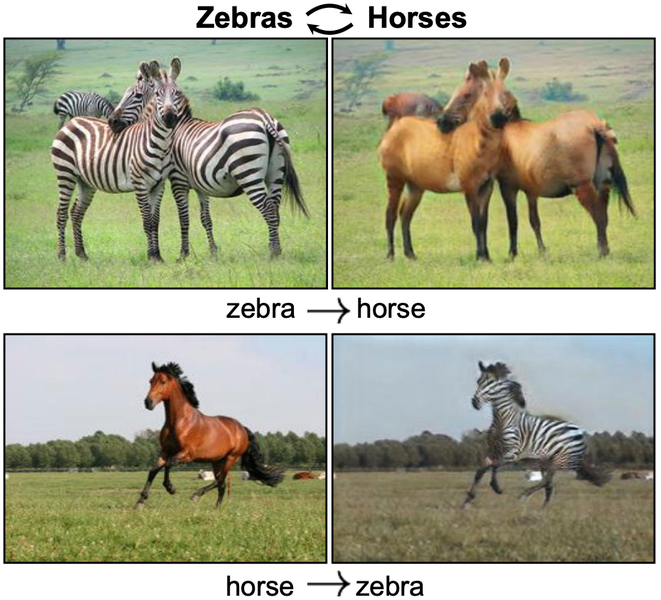
>>* 양방향으로의 이미지 변환이 가능
>>* 모델이 스스로 얼룩말과 말 데이터에서 각각의 스타일을 학습해서 새로운 이미지에 그 스타일을 입힐 수 있도록 설계되어 쌍(paired data)이 필요 없음
>>* 데이터를 구하기 훨씬 쉽고, 라벨을 붙이는 주석(annotation) 비용이 필요 없다는 것을 뜻하니, 굉장히 큰 장점!!
>>* 유명한 활용 사례는 바로 실제 사진을 모네 또는 고흐 같은 화가가 그린 그림처럼 바꾸는 것

**✓ Style Transfer이란?**
![](https://aiffelstaticprd.blob.core.windows.net/media/images/StyleTransfer.max-800x600.png)
>* 이미지의 스타일을 변환
>* 전체 이미지의 구성을 유지하고 싶은 Base Image와 입히고 싶은 스타일이 담긴 Style Image 두 장을 활용해 새로운 이미지를 만들어 내는 것
>* 즉, Base Image에서는 Content(내용)만, 그리고 Style Image에서는 Style(스타일)만 추출해서 합친 결과물
>* **`Neural`**은 신경망, 즉 딥러닝 기술을 사용했다는 뜻
>* Base Image의 내용은 잃지 않으면서, Style Image의 스타일을 효과적으로 입히기 위한 정교한 손실함수들이 짜여져 있음!

**✓ Fashion MNIST**이란?
>* 손글씨 MNIST 데이터셋을 대신해서 자주 사용
>* 70,000장 (training set 60,000장 / test set 10,000장)의 데이터셋으로 구성
>* [읽고오기](https://github.com/zalandoresearch/fashion-mnist)

>* Fashion MNIST가 만들어진 이유는?
>>* MNIST는 너무 쉽다.
>>* MNIST는 너무 많이 쓰였다.
>>* MNIST는 요즘의 Computer Vision 문제에 적용될 수 없다.

>* 각 카테고리의 Label?
>>* 0 : T-shirt/top
>>* 1 : Trouser
>>* 2 : Pullover
>>* 3 : Dress
>>* 4 : Coat
>>* 5 : Sandal
>>* 6 : Shirt
>>* 7 : Sneaker
>>* 8 : Bag
>>* 9 : Ankle boot

**✓ GAN(Generative Adversarial Network)**이란?
>* 비지도 학습에 사용되는 인공지능 알고리즘
>* 제로섬 게임 틀 안에서 서로 경쟁하는 두 개의 신경 네트워크 시스템에 의해 구현(2014년에 이안 굿펠로우)

>* **확률분포(Probability Distribution)**란?
>> * 확률 변수가 특정한 값을 가질 확률을 나타내는 함수를 의미
>> * Generator가 들어가는 모든 모델에 대해 해당하는 내용

>* **랜덤변수(Random Variable)**이란?
>> * 측정할 때마다 다른 값
>> * 특정한 확률분포를 따르는 숫자를 생성
>> * 랜덤변수에 대한 확률분포를 안다는 이야기는 랜덤변수 즉 데이터에 대한 전부를 이해하고 있다는 것과 같음!

GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

* 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
* 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
* 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

### Step1. 작업환경 구성하기
---
**✓ 다음과 같이 작업환경을 구성합시다.**

> $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples

> $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints

> $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

신경망 구성에 필요한 텐서플로우를 포함해서, 이미지와 GIF를 다루는 데 쓰이는 **imageio, display, matplotlib, PIL** 등 여러 가지 패키지가 필요합니다.<br>
**imageio, pillow** 라이브러리도 필요합니다. 없으면 설치하세요.

터미널에서 **`pip install [패키지명]`**을 사용해 필요한 패키지를 설치해 주세요.
아래 명령어를 복사해서 설치해도 됩니다.

> $ pip install imageio

> $ pip install Pillow

**✓ 다음과 같이 작업환경을 구성합시다.**

In [1]:
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import layers
from IPython import display

print("tensorflow", tf.__version__)

tensorflow 2.2.0


* **`fashion_mnist`** : 인터넷에서 따로 다운받을 필요 없이,**`tf.keras`** 안에 있는 **`datasets`**에 이미 들어가 있어서 꺼내기만 하면 됩니다.
* **`load_data()`**로 데이터를 로딩해 볼 텐데, MNIST 데이터로 분류 문제를 풀었을 때처럼 분류에 필요했던 **`y_train`**, **`y_test`**에 해당하는 데이터는 필요 없습니다.(코드에서 **`_`** (언더스코어)로 해당 데이터들은 무시)

**TIPS]** [파이썬 언더스코어(_)에 대하여](https://mingrammer.com/underscore-in-python/#2-%EA%B0%92%EC%9D%84-%EB%AC%B4%EC%8B%9C%ED%95%98%EA%B3%A0-%EC%8B%B6%EC%9D%80-%EA%B2%BD%EC%9A%B0)

### Step2. 데이터셋 구성하기
---
CIFAR-10 데이터셋도 **tf.keras** 안에 있는 **datasets**에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


정규화가 필요한지 확인해 볼까요?

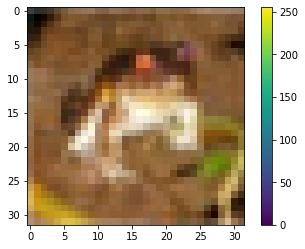

In [4]:
plt.imshow(train_x[0])
plt.colorbar()  # 오른쪽에 각 픽셀의 값과 그에 따른 색도 확인
plt.show()

음...사실 그냥 봐도 잘 모르겠네요. 🤔

**✓ 학습에 사용할 `train_x`의 이미지를 [-1, 1]로 정규화** : 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나누기

In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
train_x.dtype

dtype('float64')

**✓ 로드한 학습 데이터를 시각화를 통해 확인**

첫 번째 데이터를 꺼내서 어떻게 생겼는지 확인해 볼까요?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


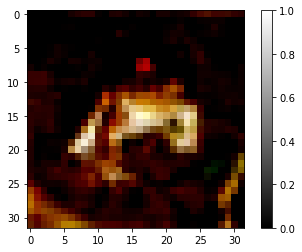

In [7]:
plt.imshow(train_x[0].reshape(32, 32, 3), cmap='gray')
plt.colorbar()  # 오른쪽에 각 픽셀의 값과 그에 따른 색도 확인
plt.show()

25개 정도를 한 번에 띄워볼까요?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

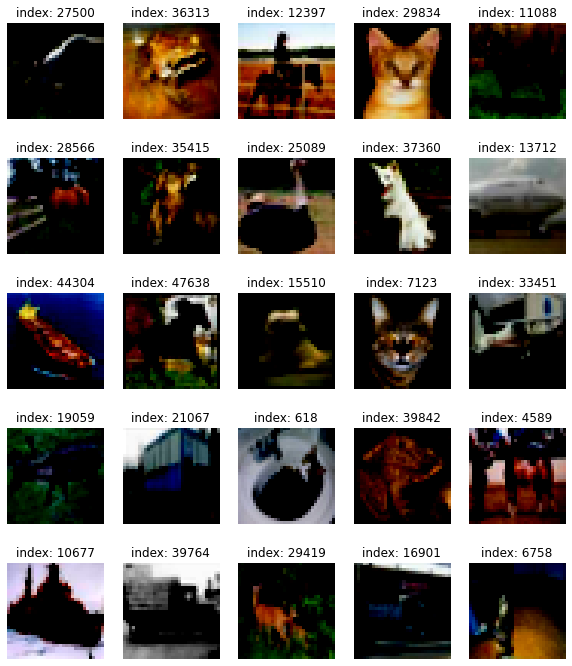

In [8]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)  # i는 range(25)으로 꺼냈으니 0~24의 숫자로 반복
                            # plt.subplot(row, col, index) : 여러 개의 이미지를 한 번에 띄우고 싶을 때
                            # plt.subplot(row, col, index) : index는 1부터 10까지 순서대로 바뀌어야 하니 for문에서 사용하는 i에 1을 i+1을 넣어줌!
    random_index = np.random.randint(1, 50000)  # numpy에서 랜덤으로 정수를 추출해주는 함수
    plt.imshow(train_x[random_index].reshape(32, 32, 3), cmap='gray')
    plt.title(f'index: {random_index}')  # 이미지에 제목으로 라벨값
    plt.axis('off')  # 불필요한 축을 지워서 깔끔하게
plt.show()

이제 데이터에 대한 전처리는 모두 마쳤습니다!

**✓ tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성** : 적절한 사이즈로 잘라서 학습을 진행(미니배치 학습)

In [9]:
BUFFER_SIZE = 50000  # 모델이 한 번에 학습할 데이터의 양 = 전체 데이터
BATCH_SIZE = 256

# shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

**TIPS]** tf.data.Dataset 모듈의 **`from_tensor_slices()`** 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다.<br>위 코드는 **`train_x`**라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다.<br>데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

### Step3. 생성자 모델 구현하기
---
* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
* **`noise = tf.random.normal([1, 100])`**로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
* 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

* **`생성자(Generator)`**는 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성해 냅니다. 즉, 무에서 유를 창조하는 것과 같은 역할을 합니다.
* **`판별자(Discriminator)`**는 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real인지, Fake인지에 대한 판단 정도를 실숫값으로 출력합니다.

In [10]:
def make_generator_model():  # 언제든 생성자를 생성하는 함수

    # Start(레이어를 차곡차곡 쌓기!)
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer : 1차원 벡터를 (7, 7, 256) 형상의 3차원 벡터로 변환시키는 작업
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer : 가장 중요한 레이어, 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())  # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))  #  tanh : -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함

    return model

In [11]:
generator = make_generator_model()
generator.summary()  # 모델 세부 내용 출력

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [12]:
# Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에
# training=False을 주어야 올바른 결과를 얻을 수 있음!
# tf.random.normal : 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만듦
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
generated_image.shape  # 이미지가 규격에 맞춰 잘 생성됐는지 확인

TensorShape([1, 32, 32, 1])

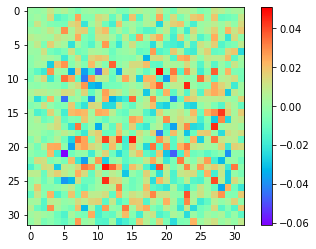

In [13]:
plt.imshow(generated_image[0, :, :, 0], cmap = 'rainbow')
plt.colorbar()
plt.show()  # 생성한 이미지 출력

**TIPS]** 텐서플로우 2.0 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성됩니다 (내부적으로는 생성자의 call 함수가 호출됩니다).

### Step4. 판별자 모델 구현하기
---
* (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
* 위 STEP 3에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [14]:
def make_discriminator_model():  # 판별자 함수

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer: Conv2D 층으로 이미지의 크기를 점점 줄여나감
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer: 3차원 이미지를 1차원으로 쭉 펴서 벡터로 변환
    model.add(layers.Flatten())

    # Fourth: Dense Layer : 단 하나의 값을 출력
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

그렇다면 아까 생성했던 가짜 이미지를 판별자에 입력시키면 어떤 결과가 나올까요?

In [16]:
decision = discriminator(generated_image, training=False)
decision

InvalidArgumentError: Matrix size-incompatible: In[0]: [1,8192], In[1]: [6272,1] [Op:MatMul]

텐서플로우의 텐서 형태로 출력이 되었습니다.

### Step5. 손실함수와 최적화 함수 구현하기
---
* 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
* 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

### Step6. 훈련과정 상세 기능 구현하기
---
* 1개 미니배치의 훈련 과정을 처리하는 **`train_step()`** 함수를 구현해 봅시다.
* 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 **`generate_and_save_images()`** 함수를 구현해 봅시다.
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 **`draw_train_history()`** 함수를 구현해 봅시다.
* **`training_checkpoints`** 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

### Step7. 학습 과정 진행하기
---
* 위 STEP 6에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

**TIPS]** 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [ ]:
# checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.

# %%time
# train(train_dataset, EPOCHS, save_every)

### Step8. (optional) GAN 훈련 과정 개선하기
---
* STEP 7을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
* 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

**TIPS]** 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻어 봅시다!
>* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
>* [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
>* [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
>* [Improved Techniques for Training GANs(paper)](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)

# <span style="color:purple">루브릭 평가 기준</span>
---
번호|평가문항|상세기준
---|---|---
1 |GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
2 |생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.|gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
3 |추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.

# <span style="color:purple">회고</span>
---